# Setup our lab 

This is a notebook tutorial about how to forecast vulnerabilities. First we'll import all the libraries we need. A couple of them need installed first. JQ is a pythonic implementation of jq; a tool for querying json files. Hurst is a library that implements a forecasting metric called the Hurst exponent, which we will use later to demonstrate that CVEs have the right properties to be forecast well.

In [ ]:
!pip install jq
!pip install hurst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 563 kB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import gzip as gz
import shutil
import pandas as pd
import json
import datetime
import tqdm
import os
import jq
import hurst
import json
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np
import chardet

In [ ]:
# Increase size of plot in jupyter
plt.rcParams["figure.figsize"] = (20,12)

The folders where we will store the data as a gzip, and as a json need to be created.

In [ ]:
!mkdir CVE-NVD
!mkdir CVE-NVD/GZIP
!mkdir CVE-NVD/JSON

Let's also setup some other folders for MITRE's advance views of CVE data.

In [ ]:
!mkdir CVE-MITRE
!mkdir CVE-MITRE/CSV

# Download the CVE data from NVD and MITRE

Now we'll download the NVD data for every year since 1999. Don't worry it's faster than you think. The progress bar comes for free from the tqdm package. 
PROTIP: Just wrap a for loop in tqdm.tqdm() it and you get a progress bar for free.
Now after this tutorial if you keep this notebook, you'll always be able to fetch all this data easily.

In [ ]:
now = datetime.datetime.now()
#PROTIP wrap an iterative loop in python with tqdm.tqdm() and you get a progress bar
for i in tqdm.tqdm(range(1999,now.year+1)):
    url = 'https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-'+str(i)+'.json.gz'
    req = requests.get(url, stream=True)
    with open('CVE-NVD/GZIP/nvdcve-1.1-'+str(i)+'.json.gz', 'wb') as f:
        for chunk in req.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                f.flush()

100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


Here we need to decompress all those gzip files so we can work with the data as json files.

In [ ]:
for i in tqdm.tqdm(range(1999,now.year+1)):
    with gz.open('CVE-NVD/GZIP/nvdcve-1.1-'+str(i)+'.json.gz', 'rb') as f_in:
        with open('CVE-NVD/JSON/nvdcve-1.1-'+str(i)+'.json', 'wb')  as f_out:
            shutil.copyfileobj(f_in, f_out)

100%|██████████| 24/24 [00:04<00:00,  5.14it/s]


Now we need to download the MITRE version of CVEs too, which gives us a different kind of information that is useful later. Specifically, it gives us a view of CVEs that didn't make the cut, and some other timestamps we can use to show when CVEs where submitted, as opposed to published. That will help us calculate the rate of publication.

In [ ]:
url = 'https://cve.mitre.org/data/downloads/allitems.csv'
req = requests.get(url, stream=True)
now = datetime.datetime.now()
with open('CVE-MITRE/CSV/allitems_current.csv', 'wb') as f:
    for chunk in req.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
            f.flush()

In [ ]:
cve_id_query = jq.compile(".CVE_Items[].cve.CVE_data_meta.ID")
cve_publication_query = jq.compile(".CVE_Items[].publishedDate")
cve_assigner_query = jq.compile(".CVE_Items[].cve.CVE_data_meta.ASSIGNER")
cvss_score_query = jq.compile(".CVE_Items[].impact.baseMetricV2.cvssV2.baseScore")
now = datetime.datetime.now()
collector = []
for i in tqdm.tqdm(range(2002, now.year+1)):
    with open('CVE-NVD/JSON/nvdcve-1.1-'+str(i)+'.json') as json_file:
        data = json.load(json_file)
        pubs = cve_publication_query.input(data).text()
        pubs = pubs.split('\n')
        pubs = [pd.to_datetime(ts.strip('"'), yearfirst=True, infer_datetime_format=True) for ts in pubs]
        index= pd.Series(pubs,name='Publication')
        cves = cve_id_query.input(data).text()
        cves = cves.split('\n')
        cves = [cve.strip('"') for cve in cves]
        assigners = cve_assigner_query.input(data).text()
        assigners = assigners.split('\n')
        cvss = cvss_score_query.input(data).text()
        cvss = cvss.split('\n')
        #print(cvss)
        s1 = pd.Series(cves,name='ID')
        s2 = pd.Series(assigners,name='ASSIGNER')
        ones = [1]*len(cves)
        s3 = pd.Series(ones,name='Count')
        s4 = pd.Series(cvss,name='CVSS')
        vulns = pd.concat([index,s1,s2,s3,s4], axis=1)
        vulns = vulns.set_index('Publication')
        collector.append(vulns)
        json_file.close()
all_items = pd.concat(collector)

100%|██████████| 21/21 [06:09<00:00, 17.58s/it]


In [ ]:
all_items.sort_index()
all_items.to_csv('NVD-Vulnerability-Volumes.csv')

In [ ]:
#all_items = pd.read_csv('NVD-Vulnerability-Volumes.csv',parse_dates=['Publication'],infer_datetime_format=True)
#all_items.set_index('Publication')

In [ ]:
# compute_Hc returns a tuple of 3 values 
H, c, data = hurst.compute_Hc(all_items['Count'].resample('D').sum(), kind='change', simplified=True)

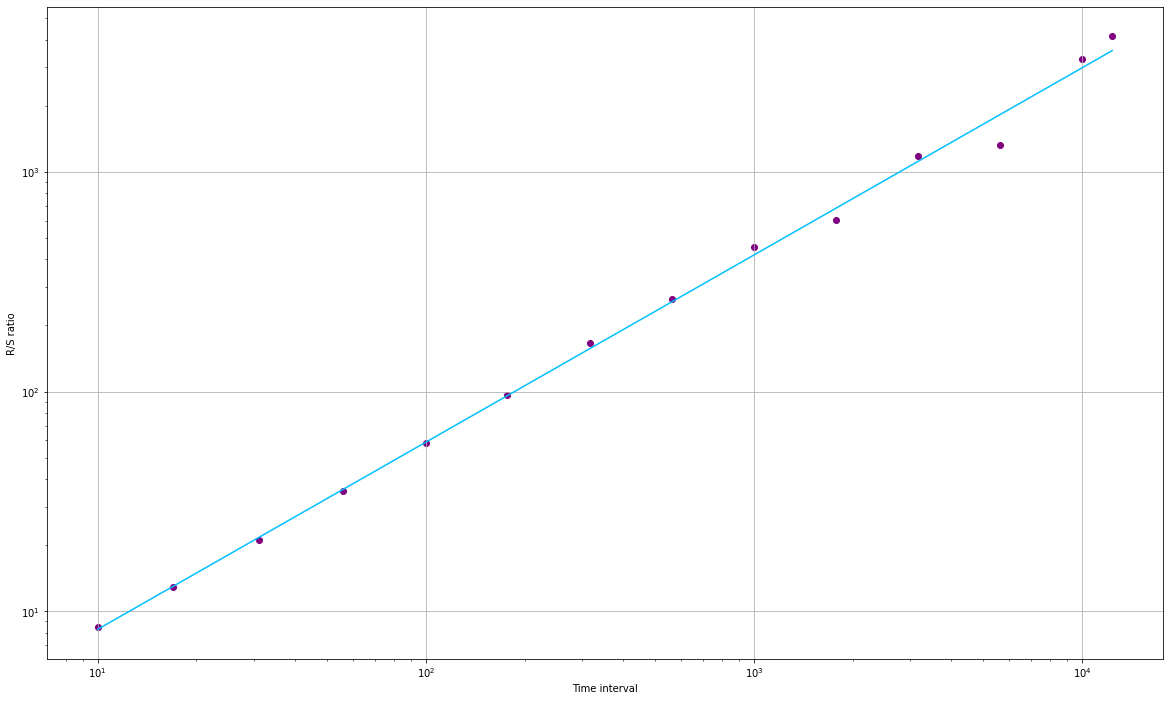

H=0.8520, c=1.1641


In [ ]:
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()
#1>H>0.5 -> Persistant behavior
#H=0.5 Brownian Motion
#0<H<0.5 Antipersistant behaviour (noisy)
print("H={:.4f}, c={:.4f}".format(H,c))

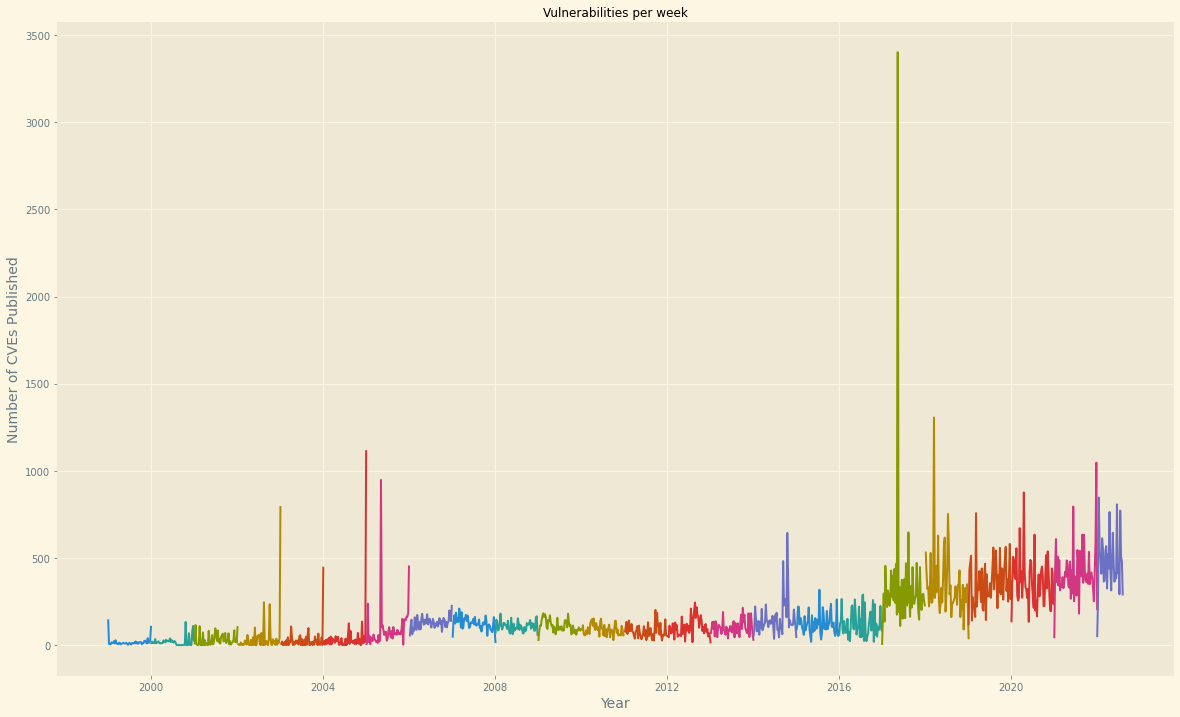

In [ ]:
now = datetime.datetime.now()
all_years = []
with plt.style.context('Solarize_Light2'):
    for i in range(1999, now.year+1):
        yearly_plot = all_items['Count'][all_items.index.year==i]
        yearly_plot = yearly_plot.sort_index()
        all_years.append(yearly_plot)
        plt.plot(yearly_plot.resample('W').sum().index,yearly_plot.resample('W').sum())
    
# Number of accent colors in the color scheme
plt.title('Vulnerabilities per week')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of CVEs Published', fontsize=14)

plt.show()

In [ ]:
#filter_date = datetime.datetime(2018, 1, 1, 1, 0) 
#date = pd.to_datetime(filter_date, format='%Y%m%d %H%M')
#all_items = all_items[all_items.index>date]
all_items = all_items.sort_index()
#Filter after 2018
#all_items.rename(columns = {'Count':'All CVEs'}, inplace = True)
all_data=all_items['Count']
drop_null = all_items[all_items.CVSS != 'null']
data_above_2 = drop_null[drop_null['CVSS'].astype(float)>2.0]['Count']
data_above_3 = drop_null[drop_null['CVSS'].astype(float)>3.0]['Count']
#data_above_4.columns.values[0] = 'CVEs Above 4.0'
data_above_4 = drop_null[drop_null['CVSS'].astype(float)>4.0]['Count']
data_above_5 = drop_null[drop_null['CVSS'].astype(float)>5.0]['Count']
data_above_6 = drop_null[drop_null['CVSS'].astype(float)>6.0]['Count']
#data_above_7.columns.values[0] = 'CVEs Above 7.0'
data_above_7 = drop_null[drop_null['CVSS'].astype(float)>7.0]['Count']
data_above_8 = drop_null[drop_null['CVSS'].astype(float)>8.0]['Count']
#data_above_9.columns.values[0] = 'CVEs Above 9.0'
data_above_9 = drop_null[drop_null['CVSS'].astype(float)>9.0]['Count']

data_above_2 = data_above_2.resample('M').sum()
data_above_3 = data_above_3.resample('M').sum()
data_above_4 = data_above_4.resample('M').sum()
data_above_5 = data_above_5.resample('M').sum()
data_above_6 = data_above_6.resample('M').sum()
data_above_7 = data_above_7.resample('M').sum()
data_above_8 = data_above_8.resample('M').sum()
data_above_9 = data_above_9.resample('M').sum()
all_data = all_data.resample('M').sum()
cve_counts = pd.concat([all_data,data_above_2,data_above_3,data_above_4,data_above_5,data_above_6,data_above_7,data_above_8,data_above_9], axis=1)

In [ ]:
cve_counts.columns.values[0] = 'Total CVE Count'
cve_counts.columns.values[1] = 'CVSS Above 2'
cve_counts.columns.values[2] = 'CVSS Above 3'
cve_counts.columns.values[3] = 'CVSS Above 4'
cve_counts.columns.values[4] = 'CVSS Above 5'
cve_counts.columns.values[5] = 'CVSS Above 6'
cve_counts.columns.values[6] = 'CVSS Above 7'
cve_counts.columns.values[7] = 'CVSS Above 8'
cve_counts.columns.values[8] = 'CVSS Above 9'
cve_counts.to_csv('CVSSProportion.csv')

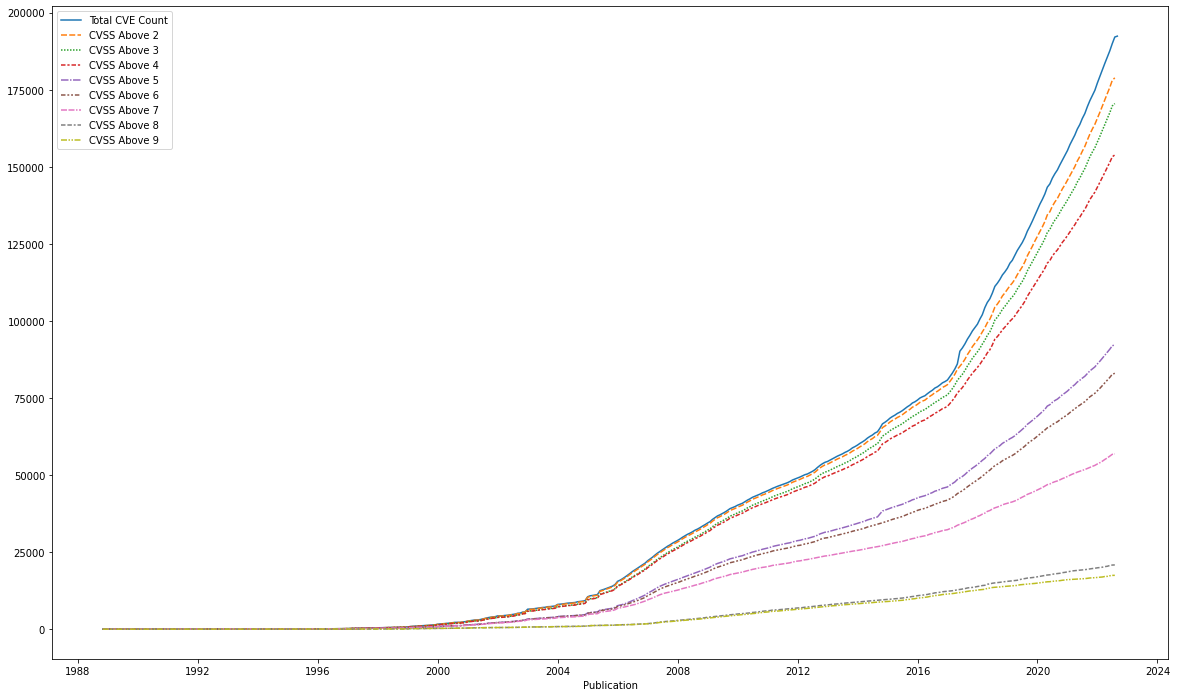

In [ ]:
#Graph the proportions of vulnerabilities by CVSS score
ax = sns.lineplot(data=cve_counts.cumsum())
plt.show()

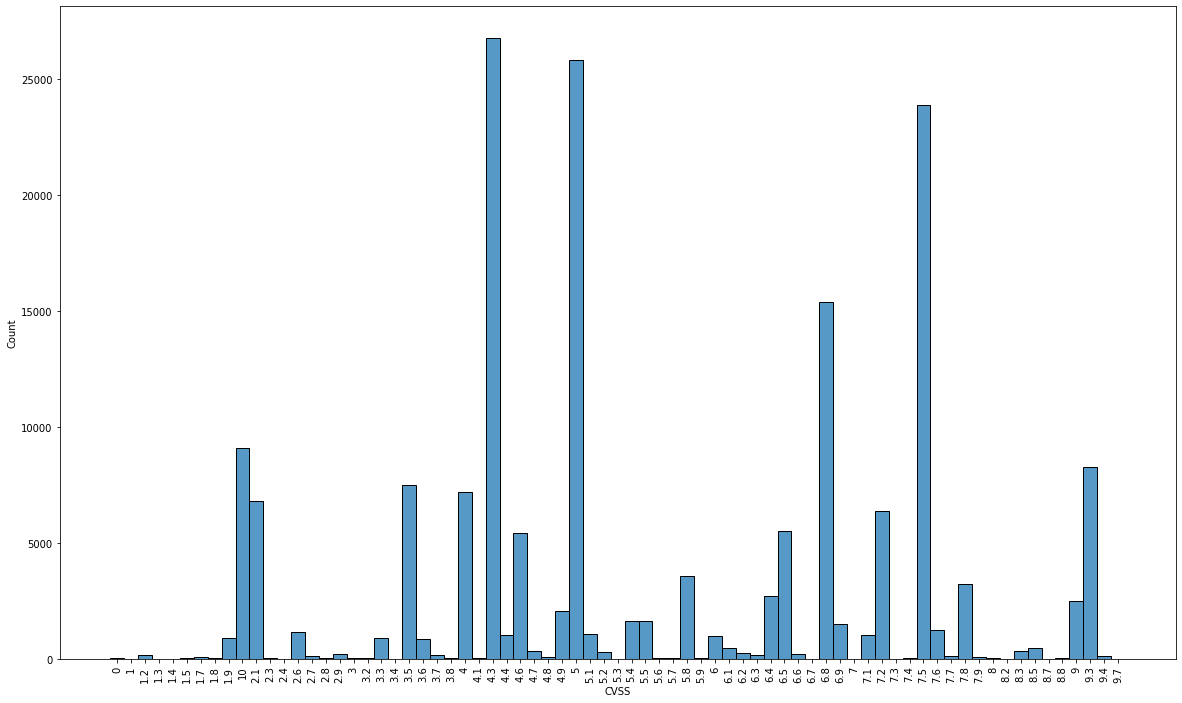

In [ ]:
ax = sns.histplot(drop_null['CVSS'].sort_values())
ax.tick_params(axis='x', rotation=90)

In [ ]:
year = now.year
ids = all_items['ID'].to_list()
this_year = []
for i in ids:
    triple = i.split('-')
    if triple[1] == str(year):
        this_year.append(triple[2])

To construct a serial number prediction forecasting model, we need to divide all the CVEs that have a string format containing this year. This will be "observations" of how many vulnerabilities have we already observed of the form CVE-2022-XXXXXX. This will allow us to estimate the size of the queue of vulnerabilities at NVD waiting for confirmation. 

In [ ]:
obs = len(this_year)
obs

We also need to use this number of observations to increase our confidence as we see more observations. To put it simply, when we've only seen on vulnerability come out, we're not very confident of our forecast, but after thousands it's much more accurate. This number of observations helps us scale our confidence.

In [ ]:
#Different but related question, how many vulnerabilities have come out this year?
this_year_count = len(all_items['Count'][all_items.index.year==now.year])
this_year_count

This number captures the number of CVEs that have been published this year, but were assigned and logged in previous years.

In [ ]:
lagged_publications = this_year_count-obs
lagged_publications

Here we finally construct our first basic forecast, a serial number prediction or "minimum variance unbiased estimator" (MVUE for short). We scale it's projections by the number of observations. For those of you who are mathematicallty minded, this is really a simple equation:

$N \approx MAXID + \frac{MAXID}{OBS} - 1$

Note how the fraction converges towards one as you witness all CVE IDs, and the -1 at the end cancels this out. This scaling factor helps us scale a lot when we have a small number of samples at the beggining of the year, and then a very small amount when we have more observations. In other words, we get more accurate the more CVEs are released.

Now don't forget this number predicts how many vulnerabilities there are with a specific format, not exactly how many will be published. In short it estimates the size of the queue waiting to be published. So we need to scale this number down by the number that will be not be published within the year. Which is roughly 5%.

In [ ]:
#Queue size
mvue = round(int(max(this_year))+(int(max(this_year))/int(obs))-1)
mvue

In [ ]:
naive_prediction_interval = round(obs-1/int(len(this_year)))
naive_prediction_interval

In [ ]:
naive_upper_prediction_interval = round(mvue*0.95+naive_prediction_interval)
naive_upper_prediction_interval

In [ ]:
naive_lower_prediction_interval = round(mvue*0.95-naive_prediction_interval)
naive_lower_prediction_interval

Now, we'll need some way of measuring the quality of forecasts which has a lovely side effect of narrowing our prediction intervals to a much more useful level.

In [ ]:
#Mean Absolute Error
def mae(Y_actual, Y_Predicted):
    return np.mean(np.abs(Y_actual - Y_Predicted))

#Mean Absolute Percentage Error
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
file = 'CVE-MITRE/CSV/allitems_current.csv'
mitre_view = pd.read_csv(file, encoding='latin1',skiprows=[0,1,3,4,5,6,7,8,9])

In [ ]:
mitre_view['Phase'].unique()
#TODO:Remove expected percentage of REJECTED
#TODO:Add prediction intervals

In [ ]:
#TODO retrocast yearly and test with MAE/MAPE


In [ ]:
#TODO Confirm this is true
average_mape = 0.08

In [ ]:
mape_lower_prediction_interval = mvue*0.95-(average_mape*mvue*0.95)
mape_lower_prediction_interval

In [ ]:
mape_upper_prediction_interval = mvue*0.95+(average_mape*mvue*0.95)
mape_upper_prediction_interval

In [ ]:
mvue*0.95

In [ ]:
#TODO Try with Little's Law

In [ ]:
assigners = all_items.ASSIGNER.dropna().to_list()
assigners = list(itertools.chain(*assigners))
unique_assigners = list(set(assigners))

In [ ]:
len(unique_assigners)

In [ ]:
this_year = all_items[all_items.index.year == now.year]
unique_this_year = this_year.ASSIGNER.dropna().to_list()
unique_this_year = list(itertools.chain(*unique_this_year))
unique_this_year = list(set(unique_this_year))

In [ ]:
for i in unique_this_year:
    assigned_by = this_year[this_year['ASSIGNER']==i.strip()]
    if not assigned_by.empty:
        print(assigned_by)

In [ ]:
len(unique_this_year)